In [1]:
import cv2 as cv
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt

import os
plt.style.use('fivethirtyeight')

## Aux functions

In [2]:
def normalize(arr):
    _arr = arr[:]
    m,M = _arr.min(),_arr.max()
    _arr -= m
    _arr /= (M-m)
    return _arr

def downsample(signal,rate):
    _signal = []
    for i in range(len(signal)):
        if i % rate == 0:
            _signal.append(signal[i])
    _signal = np.array(_signal)
    return _signal


# Analisar

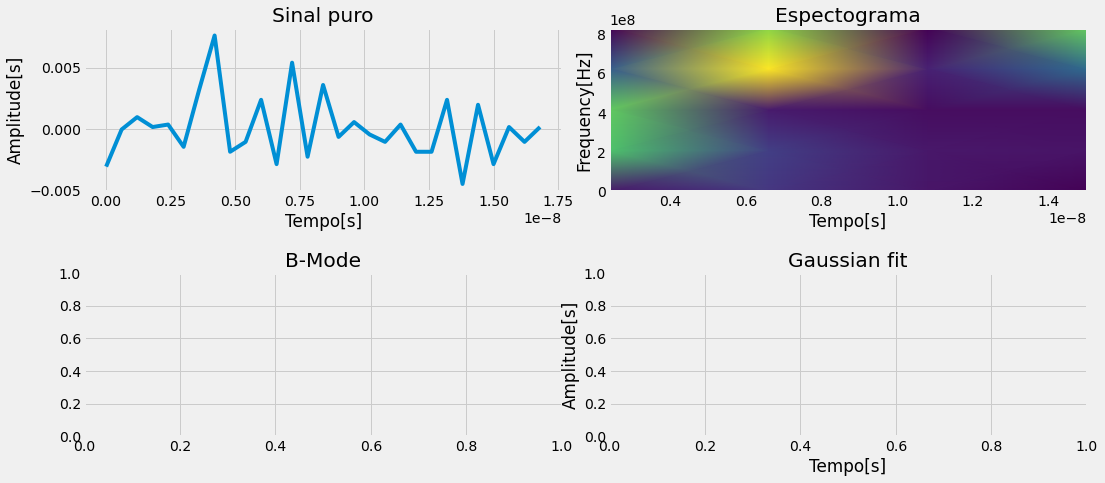

In [3]:
# Lista de arquivos ossos desmineralização 1
lista_arq_desm1=os.listdir('Dados/desm1/')
# Lista de arquivos ossos desmineralização 2
lista_arq_desm2=os.listdir('Dados/desm2/')
# Lista de arquivos ossos desmineralização 3
lista_arq_desm3=os.listdir('Dados/desm3/')
fig,axs=plt.subplots(2,2)
fig.set_size_inches((16,7))
plt.subplots_adjust(wspace=.1,hspace=.5)
width = 30

with open('Dados/desm1/'+lista_arq_desm1[160],'r') as f:
    x = f.readlines()
    dt = float(x[0])
    x = np.array(x[2:]).astype(float)
    x = downsample(x,166)
    idx = np.where(x==x.max())[0][0]
    x = x[idx-width//4:idx+3*width//4]
    _t = [i*dt for i in range(len(x))]
    axs[0][0].plot(_t,x)
    fs = 1.0/dt
    f, t, Sxx = signal.spectrogram(x, fs, scaling='density',nperseg=8)
    axs[0][1].pcolormesh(t,f,Sxx,shading='gouraud')
    
    axs[0][0].set_title("Sinal puro")
    axs[0][0].set_xlabel("Tempo[s]")
    axs[0][0].set_ylabel("Amplitude[s]")
    
    axs[0][1].set_title("Espectograma")
    axs[0][1].set_xlabel("Tempo[s]")
    axs[0][1].set_ylabel("Frequency[Hz]")
    
    axs[1][0].set_title("B-Mode")
    
    axs[1][1].set_title("Gaussian fit")
    axs[1][1].set_xlabel("Tempo[s]")
    axs[1][1].set_ylabel("Amplitude[s]")


## Extração

In [ ]:
paths = ['Dados/desm1/',
         'Dados/desm2/',
         'Dados/desm3/']

## Espectograma

In [ ]:
spec_paths = ['Espectogramas/desm1/',
              'Espectogramas/desm2/',
              'Espectogramas/desm3/']

def export_spectograms():    
                   
    for path,spec_path in list(zip(paths,spec_paths)):
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            with open(path+arq,'r') as file:
                x = file.readlines()
                dt = float(x[0])
                x = np.array(x[2:]).astype(float)
                x = downsample(x,166)
                idx = np.where(x==x.max())[0][0]
                start = idx-width//4
                end = idx+3*width//4
                if start < 0: start = 0
                if end >= len(x): end = -1
                x = x[start:end]
                fs = 1.0/dt
                f, t, Sxx = signal.spectrogram(x, fs, scaling='density',nperseg=8)
                Sxx = Sxx[1:3,:]
                if Sxx.shape[0] == 0:
                    print(path+arq)
                    print(x)
                res = np.array([Sxx.shape[0],Sxx.shape[1]])
                res = np.append(res,Sxx.reshape(Sxx.shape[0]*Sxx.shape[1],))
                with open(spec_path+arq,'w') as filespec:
                    filespec.write(' '.join(res.astype(str)))
                    filespec.close()
                file.close()
export_spectograms()

## B-mode

In [ ]:
bmode_paths = ['B-mode/desm1/',
              'B-mode/desm2/',
              'B-mode/desm3/']

c = 1700
fs = None
axial_samples = 320
num_beams = 50
beam_spacing = 0.0127

def read_data():
    for path,bmode_path in list(zip(paths,bmode_paths)):
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            with open(path+arq,'r') as file:
                x = file.readlines()
                dt = float(x[0])
                x = np.array(x[2:]).astype(float)
                while x.shape[0] < 16000:
                    ult = np.array([x[-1]])
                    x = np.append(x,ult,axis=-1)
                fs = 1./dt
                x = x.squeeze()
                matrix = np.reshape(x, (num_beams, axial_samples))
                xdim, zdim = matrix.shape
                
                dz = (c/fs)/2
                dx = beam_spacing

                # calculate lateral axis with origin (0,0) in the center
                if xdim % 2:
                    x = np.array([dx*ii
                                  for ii in range(int(-(xdim-1)/2), int((xdim-1)/2+1))])
                else:
                    x = np.array([dx*(ii+0.5)
                                  for ii in range(int(-xdim/2), int(xdim/2))])

                # calculate axial axis
                z = np.array([dz*ii for ii in range(0, zdim)])

                # generate mesh using calculated axial and lateral axes
                axi, lat = np.meshgrid(z, x, indexing='xy')
                
                fig = plt.figure(frameon=False)
                ax = plt.Axes(fig, [0., 0., 1., 1.])
                ax.set_axis_off()
                fig.add_axes(ax)
                plt.pcolormesh(lat, axi, matrix, cmap='gray')
                plt.savefig(bmode_path+arq[:-4]+'.png')
                plt.close(fig)
                
                file.close()
read_data()